In [1]:
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
from scipy import stats

Read in OHLC Data & Calculate Simple/Objective Indicators

In [2]:
time_interval_in_minutes = 5

btc_usdt_df = pd.read_csv('data/BTCUSDT.csv')
eth_usdt_df = pd.read_csv('data/ETHUSDT.csv')

dataframes = [btc_usdt_df, eth_usdt_df]

for df in dataframes:
    df.columns = map(str.lower, df.columns)
    df.drop(['close time', 'volume', 'taker buy base', 'taker buy quote', 'ignore'], axis=1, inplace=True)
    df.rename(columns={'quote asset volume': 'volume_usd', 'number of trades': 'num_trades', 'open time': 'time'}, inplace=True)
    df['time'] = pd.to_datetime(df['time'])
    df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['sma50'] = ta.trend.sma_indicator(df['close'], window=50)
    df['sma100'] = ta.trend.sma_indicator(df['close'], window=100)
    df['sma200'] = ta.trend.sma_indicator(df['close'], window=200)
    df['date'] = df['time'].dt.date
    df['vwap'] = df.groupby('date').apply(lambda x: (x['close'] * x['volume_usd']).cumsum() / x['volume_usd'].cumsum()).reset_index(level=0, drop=True)
    df.drop('date', axis=1, inplace=True)
    df['hlc_3'] = (df['high'] + df['low'] + df['close'])/3
    df['dist_to_sma50'] = df['hlc_3'] - df['sma50']
    df['dist_to_sma100'] = df['hlc_3'] - df['sma100']
    df['dist_to_sma200'] = df['hlc_3'] - df['sma200']
    df['dist_to_vwap'] = df['hlc_3'] - df['vwap']
    df[['atr', 'rsi', 'sma50', 'sma100','sma200']] = df[['atr', 'rsi', 'sma50', 'sma100','sma200']].round(2)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
# Don't want to use whole 250k rows while testing code.
btc_usdt_df = btc_usdt_df.head(20000)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

Define & Calculate Complex/Subjective Indicators

In [ ]:
########### find_horizontal_resistance_lines_and_touch_points ###########

#--> Identifies an "origin" green candle for resistance line starting point. 
#--> Defines the resistance 'line_price' as a weighted mean of the origin candle's high and close prices. 
# (This is superior to HLC/3 because we are only interested in the high wicks for resistance lines). 
#--> The 'waiting_period' and the 'waiting_candles' is a way to separate 'clumped' candle touches to have min # candles between origin point and 2nd touch. 
#--> Checks the following candles for touch points, using % of atr as wiggle room to define an acceptable range for touch points.
#--> Makes sure there are no overlapping lines during line creation.

########### find_horizontal_resistance_lines_and_touch_points ###########

In [3]:
def find_horizontal_resistance_lines_and_touch_points(df):
    resistance_lines = []
    i = 0
    waiting_period = 10

    while i < len(df) - waiting_period: 
        origin_candle = df.iloc[i]

        if origin_candle['close'] > origin_candle['open']:
            line_price = 0.6 * origin_candle['close'] + 0.4 * origin_candle['high'] 
            touch_points = {}
            touch_prices = {}
            last_touch_point_index = i

            waiting_candles = df.iloc[i+1:i+waiting_period+1]
            waiting_candles_upper_range = line_price + (0.5 * waiting_candles['atr'])
            waiting_candles_line_price = 0.6 * waiting_candles[['close', 'open']].max(axis=1) + 0.4 * waiting_candles['high']
            
            if any(waiting_candles_line_price > waiting_candles_upper_range):
                i += 1
                continue

            for j in range(i+waiting_period, len(df)):  
                candle = df.iloc[j]
                upper_range = line_price + (0.5 * candle['atr'])
                lower_range = line_price - (0.5 * candle['atr'])
                bottom_limit = line_price - (5 * candle['atr'])
                candle_line_price = 0.6 * candle[['close', 'open']].max() + 0.4 * candle['high']
                candle_line_price_bottom = 0.6 * candle[['close', 'open']].min() + 0.4 * candle['low']

                if j - last_touch_point_index >= waiting_period and lower_range <= candle_line_price <= upper_range:
                    touch_points[f'touch_point_{len(touch_points)+2}'] = candle['time']
                    touch_prices[f'touch_point_{len(touch_prices)+2}_price'] = candle_line_price
                    last_touch_point_index = j

                if candle_line_price > upper_range or candle_line_price_bottom < bottom_limit:
                    if len(touch_points) > 0:
                        line = {'initial_point': origin_candle['time'], 'end_of_line': candle['time'], 'line_price': line_price}
                        line.update(touch_points)
                        line.update(touch_prices)
                        resistance_lines.append(line)
                    i = j + 1
                    break
            else:
                i += 1
        else:
            i += 1

    return pd.DataFrame(resistance_lines)

resistance_lines_df = find_horizontal_resistance_lines_and_touch_points(btc_usdt_df)

In [4]:
# Add columns
time_interval_in_minutes = 5
resistance_lines_df['line_length'] = (resistance_lines_df['end_of_line'] - resistance_lines_df['initial_point']).dt.total_seconds() / (time_interval_in_minutes * 60)
resistance_lines_df['line_length'] = resistance_lines_df['line_length'].astype(int)
resistance_lines_df['3rd_touch_bool'] = resistance_lines_df['touch_point_3'].notna()
resistance_lines_df['num_touch_points'] = resistance_lines_df.filter(regex='touch_point_\d+$').count(axis=1) + 1

# Sort columns
static_columns = ['initial_point', 'end_of_line', 'line_length', 'line_price', 'num_touch_points', '3rd_touch_bool']
touch_point_columns = [col for col in resistance_lines_df.columns if 'touch_point' in col and col != 'num_touch_points']
touch_point_columns.sort(key=lambda x: int(x.split('_')[-2]) if x.split('_')[-1] == 'price' else int(x.split('_')[-1]))
ordered_columns = static_columns + touch_point_columns
resistance_lines_df = resistance_lines_df[ordered_columns]
resistance_lines_df.head(10)

,initial_point,end_of_line,line_length,line_price,num_touch_points,3rd_touch_bool,touch_point_2,touch_point_2_price,touch_point_3,touch_point_3_price,touch_point_4,touch_point_4_price,touch_point_5,touch_point_5_price,touch_point_6,touch_point_6_price,touch_point_7,touch_point_7_price
0,2020-12-17 06:25:00,2020-12-17 07:20:00,11,22270.064,2,False,2020-12-17 07:15:00,22288.760,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
1,2020-12-17 09:25:00,2020-12-17 13:05:00,44,23162.428,2,False,2020-12-17 12:55:00,23169.594,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
2,2020-12-17 13:35:00,2020-12-17 16:05:00,30,23326.852,2,False,2020-12-17 15:50:00,23270.470,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
3,2020-12-17 16:30:00,2020-12-17 18:15:00,21,23642.482,2,False,2020-12-17 17:20:00,23587.012,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
4,2020-12-17 20:50:00,2020-12-17 22:00:00,14,22721.138,2,False,2020-12-17 21:40:00,22696.168,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
5,2020-12-17 22:45:00,2020-12-18 02:15:00,42,23044.328,3,True,2020-12-18 01:15:00,22996.666,2020-12-18 02:05:00,23065.744,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
6,2020-12-18 05:05:00,2020-12-18 06:05:00,12,23006.120,2,False,2020-12-18 06:00:00,22977.098,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
7,2020-12-18 14:00:00,2020-12-18 16:50:00,34,22690.784,2,False,2020-12-18 16:35:00,22687.952,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
8,2020-12-18 17:45:00,2020-12-18 21:00:00,39,22800.496,3,True,2020-12-18 18:45:00,22774.192,2020-12-18 20:00:00,22776.656,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
9,2020-12-18 21:25:00,2020-12-18 23:50:00,29,23063.728,2,False,2020-12-18 23:45:00,23056.972,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN


Define a Trading Strategy

In [12]:
########### trading_strategy ###########

#--> Uses the opening price of the candle after the horizontal lines third touch point as an entry.
#--> Defines the stop loss level as 1.3*atr below the entry, and the take profit level as 3*atr above the entry.
#--> Iterates through the sliced data looking for sl/tp/neither.
#--> Adds columns to trades_df

########### trading_strategy ###########

In [5]:
def trading_strategy(df, resistance_lines_df):

    trades_df = pd.DataFrame(columns=['result', 'entry_price', 'sl_main', 'tp1', 'tp2', 'tp3', 'tsl1', 'tsl2', 'entry_time', 'sl_main_time', 'tp1_time',  'tp2_time', 'tp3_time', 'tsl1_time', 'tsl2_time'])

    for idx, row in resistance_lines_df.iterrows():
        if row['num_touch_points'] < 3:
            continue
        
        third_point = row['touch_point_3']
        third_point_index = df[df['time'] == third_point].index[0]
        
        rsi = df.iloc[third_point_index]['rsi']
        dist_to_vwap = df.iloc[third_point_index]['dist_to_vwap']
        if rsi < 50 or dist_to_vwap <= 0:
            continue

        entry_price = df.iloc[third_point_index + 1]['open']
        entry_time = df.iloc[third_point_index + 1]['time']
        slice_df = df.iloc[third_point_index + 1:]

        result = 'None'
        sl_main_time = None
        tp1_time = None
        tp2_time = None
        tp3_time = None
        tsl1_time = None
        tsl2_time = None

        for _, candle in slice_df.iterrows():
            atr = candle['atr']
            sl_main = entry_price - 1.3 * atr
            tp1 = entry_price + 2 * atr
            tp2 = entry_price + 3 * atr
            tp3 = entry_price + 4 * atr
            tsl1 = entry_price
            tsl2 = tp1

            if candle['low'] <= sl_main and result == 'None':
                result = 'sl_main_hit'
                sl_main_time = candle['time']
                break
            elif candle['high'] >= tp1 and result == 'None':
                result = 'tp1_hit_then_tsl1'
                tp1_time = candle['time']
            elif candle['low'] <= tsl1 and result == 'tp1_hit_then_tsl1':
                tsl1_time = candle['time']
                break
            elif candle['high'] >= tp2 and result == 'tp1_hit_then_tsl1':
                result = 'tp2_hit_then_tsl2'
                tp2_time = candle['time']
            elif candle['low'] <= tsl2 and result == 'tp2_hit_then_tsl2':
                tsl2_time = candle['time']
                break
            elif candle['high'] >= tp3 and result == 'tp2_hit_then_tsl2':
                result = 'tp3_hit'
                tp3_time = candle['time']
                break

        new_row = pd.DataFrame({'result': [result], 'entry_price': [entry_price], 'sl_main': [sl_main], 'tp1': [tp1], 'tp2': [tp2], 'tp3': [tp3], 'tsl1': [tsl1], 'tsl2': [tsl2], 'entry_time': [entry_time], 'sl_main_time': [sl_main_time], 'tp1_time': [tp1_time], 'tp2_time': [tp2_time], 'tp3_time': [tp3_time], 'tsl1_time': [tsl1_time], 'tsl2_time': [tsl2_time]
        })
        trades_df = pd.concat([trades_df, new_row], ignore_index=True)
    return trades_df
trades_df = trading_strategy(btc_usdt_df, resistance_lines_df)

In [10]:
# Add columns
trades_df['pos_size'] = 10000
trades_df['fee'] = 0.001 * trades_df['pos_size']

result_to_time_col = {'sl_main_hit': 'sl_main_time', 'tp1_hit_then_tsl1': 'tsl1_time', 'tp2_hit_then_tsl2': 'tsl2_time', 'tp3_hit': 'tp3_time'}
trades_df['exit_time'] = trades_df.apply(lambda row: row[result_to_time_col[row['result']]], axis=1)
trades_df['trade_length_minutes'] = (trades_df['exit_time'] - trades_df['entry_time']).dt.total_seconds() / 60
trades_df['trade_length_candles'] = (trades_df['trade_length_minutes'] / time_interval_in_minutes).astype(int)

result_to_exit_info = {
    'sl_main_hit': [('sl_main', 1.0)],
    'tp1_hit_then_tsl1': [('tp1', 0.5), ('tsl1', 0.5)],
    'tp2_hit_then_tsl2': [('tp1', 0.5), ('tp2', 0.25), ('tsl2', 0.25)],
    'tp3_hit': [('tp1', 0.5), ('tp2', 0.25), ('tp3', 0.25)]
}

result_to_exit_price_col = {'sl_main_hit': 'sl_main', 'tp1_hit_then_tsl1': 'tsl1', 'tp2_hit_then_tsl2': 'tsl2', 'tp3_hit': 'tp3'}
trades_df['exit_price'] = trades_df.apply(lambda row: row[result_to_exit_price_col[row['result']]], axis=1)

def calculate_pl_b4_fee(row):
    pl_b4_fee = 0
    for exit_info in result_to_exit_info[row['result']]:
        exit_price_col, percentage = exit_info
        exit_price = row[exit_price_col]
        pl_b4_fee += (exit_price - row['entry_price']) * (row['pos_size'] * percentage / row['entry_price'])
    return pl_b4_fee

trades_df['pl_b4_fee'] = trades_df.apply(calculate_pl_b4_fee, axis=1)
trades_df['net_pl_with_fee'] = trades_df['pl_b4_fee'] - trades_df['fee']

# Sort columns
sorted_columns = ['result', 'entry_price', 'exit_price', 'sl_main', 'tp1', 'tp2', 'tp3', 'tsl1', 'tsl2', 'entry_time', 'exit_time', 'sl_main_time', 'tp1_time', 'tp2_time', 'tp3_time', 'tsl1_time', 'tsl2_time', 'pos_size', 'pl_b4_fee', 'fee', 'net_pl_with_fee', 'trade_length_minutes', 'trade_length_candles']
trades_df = trades_df[sorted_columns]
pd.set_option('display.max_rows', 100)
trades_df.head(100)

,result,entry_price,exit_price,sl_main,tp1,tp2,tp3,tsl1,tsl2,entry_time,exit_time,sl_main_time,tp1_time,tp2_time,tp3_time,tsl1_time,tsl2_time,pos_size,pl_b4_fee,fee,net_pl_with_fee,trade_length_minutes,trade_length_candles
0,sl_main_hit,23064.57,22945.880,22945.880,23247.17,23338.47,23429.77,23064.57,23247.17,2020-12-18 02:10:00,2020-12-18 03:00:00,2020-12-18 03:00:00,NaT,NaT,NaT,NaT,NaT,10000,-51.459880,10.0,-61.459880,50.0,10
1,tp2_hit_then_tsl2,23046.75,23150.550,22979.280,23150.55,23202.45,23254.35,23046.75,23150.55,2020-12-19 02:00:00,2020-12-19 03:05:00,None,2020-12-19 02:40:00,2020-12-19 02:55:00,NaT,NaT,2020-12-19 03:05:00,10000,50.668749,10.0,40.668749,65.0,13
2,tp3_hit,23056.31,23356.470,22958.758,23206.39,23281.43,23356.47,23056.31,23206.39,2020-12-19 12:35:00,2020-12-19 14:05:00,None,2020-12-19 13:50:00,2020-12-19 14:00:00,2020-12-19 14:05:00,NaT,None,10000,89.502613,10.0,79.502613,90.0,18
3,tp2_hit_then_tsl2,23583.40,23742.500,23479.985,23742.50,23822.05,23901.60,23583.40,23742.50,2020-12-20 15:10:00,2020-12-20 16:15:00,None,2020-12-20 15:30:00,2020-12-20 15:45:00,None,NaT,2020-12-20 16:15:00,10000,75.895545,10.0,65.895545,65.0,13
4,tp1_hit_then_tsl1,23889.99,23889.990,23808.844,24014.83,24077.25,24139.67,23889.99,24014.83,2020-12-20 19:45:00,2020-12-20 20:05:00,None,2020-12-20 20:00:00,None,None,2020-12-20 20:05:00,None,10000,26.128098,10.0,16.128098,20.0,4
5,tp2_hit_then_tsl2,23547.90,23683.540,23459.734,23683.54,23751.36,23819.18,23547.90,23683.54,2020-12-21 00:20:00,2020-12-21 02:20:00,None,2020-12-21 01:05:00,2020-12-21 02:10:00,None,None,2020-12-21 02:20:00,10000,64.801957,10.0,54.801957,120.0,24
6,sl_main_hit,22886.41,22776.703,22776.703,23055.19,23139.58,23223.97,22886.41,23055.19,2020-12-22 02:40:00,2020-12-22 03:15:00,2020-12-22 03:15:00,None,None,None,None,None,10000,-47.935434,10.0,-57.935434,35.0,7
7,sl_main_hit,22780.59,22666.138,22666.138,22956.67,23044.71,23132.75,22780.59,22956.67,2020-12-22 09:05:00,2020-12-22 09:35:00,2020-12-22 09:35:00,None,None,None,None,None,10000,-50.241017,10.0,-60.241017,30.0,6
8,tp2_hit_then_tsl2,23559.94,23712.380,23460.854,23712.38,23788.60,23864.82,23559.94,23712.38,2020-12-22 22:50:00,2020-12-22 23:40:00,None,2020-12-22 22:55:00,2020-12-22 23:35:00,None,None,2020-12-22 23:40:00,10000,72.790932,10.0,62.790932,50.0,10
9,tp2_hit_then_tsl2,23359.08,23466.100,23289.517,23466.10,23519.61,23573.12,23359.08,23466.10,2020-12-24 20:25:00,2020-12-24 21:05:00,None,2020-12-24 20:50:00,2020-12-24 20:55:00,None,None,2020-12-24 21:05:00,10000,51.542056,10.0,41.542056,40.0,8


Analyze Trading Strategy

In [7]:
# Slices 'btc_usdt_df' into manageable plotting amount.
plt_btc_usdt_df = btc_usdt_df.head(4000)

last_timestamp = plt_btc_usdt_df['time'].iloc[-1]

# Corresponds the last timestamp of price data chunk to the trade results and resistance lines.
mask = resistance_lines_df['end_of_line'] <= last_timestamp
mask_two = trades_df['exit_time'] <= last_timestamp
plt_resistance_lines_df = resistance_lines_df[mask]
plt_trade_results_df = trades_df[mask_two]

In [8]:
# PLOTLY CRASHES IF USING TOO MANY ROWS, THIS IS JUST TO MAKE SURE TRADES LOOK RIGHT AND LOOK AT SOME TRADES
# PLOTLY CRASHES IF USING TOO MANY ROWS, THIS IS JUST TO MAKE SURE TRADES LOOK RIGHT AND LOOK AT SOME TRADES
# PLOTLY CRASHES IF USING TOO MANY ROWS, THIS IS JUST TO MAKE SURE TRADES LOOK RIGHT AND LOOK AT SOME TRADES

# Candlestick plot (With the horizontal lines, all the line touch points, trade entry, trade exit)

fig = make_subplots(specs=[[{"secondary_y": True}]])

candlesticks = go.Candlestick(x=plt_btc_usdt_df['time'], open=plt_btc_usdt_df['open'], high=plt_btc_usdt_df['high'], low=plt_btc_usdt_df['low'], close=plt_btc_usdt_df['close'], name='Candlesticks')

line_origin = go.Scatter(x=plt_resistance_lines_df['initial_point'], y=plt_resistance_lines_df['line_price'], mode='markers', name='Line Origin', marker=dict(color='#39FF14', size=7))
line_end = go.Scatter(x=plt_resistance_lines_df['end_of_line'], y=plt_resistance_lines_df['line_price'], mode='markers', name='Line End', marker=dict(color='#39FF14', size=7))

entries = go.Scatter(x=plt_trade_results_df['entry_time'], y=plt_trade_results_df['entry_price'], mode='markers', name='Entry', marker=dict(color='#FFD700', size=7))
exits = go.Scatter(x=plt_trade_results_df['exit_time'], y=plt_trade_results_df['exit_price'], mode='markers', name='Exit', marker=dict(color='#FFD700', size=7))
atr = go.Scatter(x=plt_btc_usdt_df['time'], y=plt_btc_usdt_df['atr'], mode='lines', name='ATR', line=dict(color='#FC0FC0'), opacity=0.2)

fig.add_trace(candlesticks, secondary_y=False)
fig.add_trace(line_origin, secondary_y=False)
fig.add_trace(line_end, secondary_y=False)

# Adds all the touch points starting with 'touch_point_2'
for i in range(2, len(plt_resistance_lines_df.columns)):
    touch_point_column = 'touch_point_' + str(i)
    touch_price_column = 'touch_point_' + str(i) + '_price'

    if touch_point_column in plt_resistance_lines_df.columns:
        touch_points = go.Scatter(x=plt_resistance_lines_df[touch_point_column], y=plt_resistance_lines_df[touch_price_column], mode='markers', name=f'Touch Point {i}', marker=dict(color='#B200ED', size=7))
        fig.add_trace(touch_points, secondary_y=False)

fig.add_trace(entries, secondary_y=False)
fig.add_trace(exits, secondary_y=False)
fig.add_trace(atr, secondary_y=True)

fig.update_layout(title='BTC/USDT', xaxis_title='Time', template="plotly_dark", legend=dict(y=1.2, font=dict(size=12)))
fig.update_yaxes(title_text='Price', secondary_y=False, tickformat="$,.2f", autorange=True, fixedrange=False)
fig.update_yaxes(title_text='ATR', secondary_y=True)

# Adds the horizontal resistance lines to graph. Iterates through each row of the resistance_df.
for _, row in plt_resistance_lines_df.iterrows():
    start_time = row['initial_point']
    end_time = row['end_of_line']
    price = row['line_price']
    
    fig.add_shape(type="line", x0=start_time, y0=price, x1=end_time, y1=price, line=dict(color='#39FF14', width=2), xref='x', yref='y')

fig.show()

In [11]:
num_sl_main = trades_df['result'].value_counts().get('sl_main_hit', 0)
num_tsl1 = trades_df['result'].value_counts().get('tp1_hit_then_tsl1', 0)
num_tsl2 = trades_df['result'].value_counts().get('tp2_hit_then_tsl2', 0)
num_tp3 = trades_df['result'].value_counts().get('tp3_hit', 0)
num_wins = num_tsl1 + num_tsl2 + num_tp3
num_losses = num_sl_main
total_trades = trades_df['result'].count()

trade_stats_df = pd.DataFrame({
    'pl total': [trades_df['net_pl_with_fee'].sum()],
    'avg_pl_per_trade': [trades_df['net_pl_with_fee'].mean()],
    'num_sl_main': [num_sl_main],
    'num_tsl1': [num_tsl1],
    'num_tsl2': [num_tsl2],
    'num_tp3': [num_tp3],
    'num_wins': [num_wins],
    'num_losses': [num_losses],
    'total_trades': [total_trades],
    'win_pct': [num_wins / total_trades if total_trades > 0 else 0],
    'loss_pct': [num_losses / total_trades if total_trades > 0 else 0],
    'avg_trade_length': [trades_df['trade_length_candles'].mean()],
    'max_trade_length': [trades_df['trade_length_candles'].max()],
    'min_trade_length': [trades_df['trade_length_candles'].min()]
})

trade_stats_df = trade_stats_df.style.format('{:,.2f}').set_properties(**{'text-align': 'center'})

trade_stats_df

# Min length trade of 0 is working as intended --> exits that happened within the entry candle, since entries are on the candles open.

,pl total,avg_pl_per_trade,num_sl_main,num_tsl1,num_tsl2,num_tp3,num_wins,num_losses,total_trades,win_pct,loss_pct,avg_trade_length,max_trade_length,min_trade_length
0,514.13,6.68,40.00,4.00,18.00,15.00,37.00,40.00,77.00,0.48,0.52,8.17,30.00,0.00


In [10]:
########### returns_from_entry ###########
#--> 'e' stands for entry.
#--> Returns are calculated as (current hlc/3) - entry_price
#--> Good for determining a trading strategy or backtesting/optimizing for SL/TP/etc. (Use bulk data eventually)
#--> 'e+0' will reflect the price change that happened within the 'entry_time' candle itself, (since trades executed on open of candle)

########### returns_from_entry ###########

In [12]:
def returns_from_entry(btc_usdt_df, trades_df):
    returns_dict = {}

    for idx, row in trades_df.iterrows():

        entry_price = row['entry_price']
        entry_time = row['entry_time']
        
        start_idx = btc_usdt_df.loc[btc_usdt_df['time'] == entry_time].index[0]
        end_idx = min(start_idx + 200, len(btc_usdt_df) - 1)
        slice_df = btc_usdt_df.iloc[start_idx:end_idx]

        returns_df = slice_df[['hlc_3']].copy()
        returns_df['returns'] = returns_df['hlc_3'].apply(lambda x: x - entry_price)

        returns_df.drop(columns=['hlc_3'], inplace=True)
        returns_df.reset_index(drop=True, inplace=True)
        returns_df.index = 'e+' + returns_df.index.astype(str)

        returns_dict[idx] = returns_df

    return returns_dict

returns_dict = returns_from_entry(btc_usdt_df, trades_df)

In [13]:
def create_returns_plot(analysis_dict):
    fig = go.Figure()

    for entry, returns_df in analysis_dict.items():
        returns_trace = go.Scatter(x=returns_df.index, y=returns_df['returns'], mode='lines', name=f'Trade {entry}', line=dict(color='#FFD700'), opacity=0.3)
        fig.add_trace(returns_trace)

    fig.add_hline(y=0, line=dict(color='blue', width=2, dash='dash'))

    fig.update_layout(title='Returns Over Time', xaxis_title="Candles after Entry", yaxis=dict(title='Returns', side='left', color='white'),
        showlegend=True,
        template="plotly_dark"
    )
    fig.show()

create_returns_plot(returns_dict)

max_returns = []
max_locations = []
min_returns = []
min_locations = []

for trade, returns_df in returns_dict.items():

    max_return = returns_df['returns'].max()
    max_location = returns_df['returns'].idxmax()
    min_return = returns_df['returns'].min()
    min_location = returns_df['returns'].idxmin()
    
    max_returns.append(max_return)
    max_locations.append(max_location)
    min_returns.append(min_return)
    min_locations.append(min_location)

max_locations = [int(location[2:]) for location in max_locations]
min_locations = [int(location[2:]) for location in min_locations]

overall_max_return = max(max_returns)
overall_min_return = min(min_returns)
e0_returns_sum = sum(returns_df.loc['e+0', 'returns'] for returns_df in returns_dict.values())

returns_stats_df = pd.DataFrame({
    'avg_max_return': [np.mean(max_returns)],
    'avg_min_return': [np.mean(min_returns)],
    'avg_max_return_location': [np.mean(max_locations)],
    'avg_min_return_location': [np.mean(min_locations)],
    'sum_max_returns': [np.sum(max_returns)],
    'sum_min_returns': [np.sum(min_returns)],
    'sum_min_max_returns': [np.sum(max_returns) + np.sum(min_returns)],
    'e0_returns_sum': [e0_returns_sum],
    'max_return': [overall_max_return],
    'min_return': [overall_min_return]
}).style.format('{:,.2f}').set_properties(**{'text-align': 'center'})

returns_stats_df

# e+0 is working as intended, since entries are at the candle opens, this represents the returns within that first entry candle.

,avg_max_return,avg_min_return,avg_max_return_location,avg_min_return_location,sum_max_returns,sum_min_returns,sum_min_max_returns,e0_returns_sum,max_return,min_return
0,"1,328.98",-850.60,98.30,78.68,"102,331.29","-65,496.02","36,835.27","1,473.23","7,814.83","-5,152.97"


In [14]:
# Start with $100k
portfolio_value = 100000
trades_df = trades_df.copy()

trades_df['cumulative_pl'] = trades_df['net_pl_with_fee'].cumsum().shift(fill_value=0)
trades_df['cumulative_pl'] += portfolio_value
trades_df['running_max'] = trades_df['cumulative_pl'].cummax()
trades_df['drawdown'] = trades_df['running_max'] - trades_df['cumulative_pl']
max_drawdown = trades_df['drawdown'].max()

print("Maximum Drawdown: $", round(max_drawdown, 2))
fig = go.Figure()
fig.add_trace(go.Scatter(x=trades_df.index, y=trades_df['cumulative_pl'], mode='lines', name='Portfolio Value'))
fig.update_yaxes(tickformat=",.2f")
fig.update_layout(title='Cumulative Portfolio Value', xaxis_title='Trade Number', yaxis_title='Portfolio Value', showlegend=False, template="plotly_dark")
fig.show()

Maximum Drawdown: $ 808.48


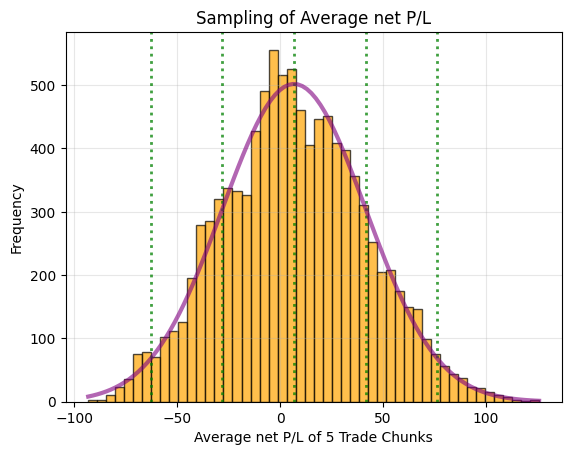

Mean: +$6.80
Average net P/L ONE std below and above the mean: (-$28.04, +$41.63)
Average net P/L TWO std below and above the mean: (-$62.88, +$76.47)


In [15]:
# Random sampling of 5 trades, for 10,000 iterations to get a distribution of random trades.
sample_size=5
iterations=10000

def random_sample_avg_pl(trades_df, sample_size, iterations):
    all_pl = trades_df['net_pl_with_fee'].tolist()
    avg_pl_samples = []

    for _ in range(iterations):
        random_pl_sample = random.sample(all_pl, sample_size)
        avg_pl_samples.append(np.mean(random_pl_sample))
    return avg_pl_samples

avg_pl_samples = random_sample_avg_pl(trades_df, sample_size, iterations)

# Fit a Gaussian distribution, returning the mean and standard deviation. Generate 100 evenly spaced numbers in an array between min and max values of avg_pl_samples
mu, sigma = stats.norm.fit(avg_pl_samples)
x = np.linspace(min(avg_pl_samples), max(avg_pl_samples), 100)

# Probability Density Function, & calculates std's from the mean.
pdf = stats.norm.pdf(x, mu, sigma)
one_std_left = mu - sigma
one_std_right = mu + sigma
two_std_left = mu - 2*sigma
two_std_right = mu + 2*sigma

# Plot vertical lines for the mean and std's
plt.axvline(mu, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
plt.axvline(one_std_left, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
plt.axvline(one_std_right, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
plt.axvline(two_std_left, color='green', linestyle='dotted', linewidth=2, alpha=0.75)
plt.axvline(two_std_right, color='green', linestyle='dotted', linewidth=2, alpha=0.75)

# Plot the histogram
n, bins, patches = plt.hist(avg_pl_samples, bins='auto', color='orange', edgecolor='black', alpha=0.7)

# Rescale the Gaussian curve from probability density to the same frequency representation as the histogram
bin_width = bins[1] - bins[0]
pdf_rescaled = pdf * len(avg_pl_samples) * bin_width

# Plot rescaled Gaussian curve
plt.plot(x, pdf_rescaled, color='purple', alpha=0.6, linewidth=3)
plt.xlabel(f'Average net P/L of {sample_size} Trade Chunks')
plt.ylabel('Frequency')
plt.title('Sampling of Average net P/L')
plt.grid(True, alpha=0.3)
plt.show()

# Formatting the text output
def format_value(value):
    return f"{'+' if value >= 0 else '-'}${'{:.2f}'.format(abs(value))}"
print(f"Mean: {format_value(mu)}")
print(f"Average net P/L ONE std below and above the mean: ({format_value(one_std_left)}, {format_value(one_std_right)})")
print(f"Average net P/L TWO std below and above the mean: ({format_value(two_std_left)}, {format_value(two_std_right)})")